# Введение
В данном задании мы предлагаем вам сделать модель, которая поможет отделу госзакупок извлекать 
нужный кусок текста из документа для того, чтобы сформировать анкету заявки. То, какой именно фрагмент текста нужно извлечь, зависит от пункта анкеты, соответствующего документу.
Всего в каждом документе, с которыми вы будет работать, есть 1 из 2-х пунктов анкеты, по которым необходимо извлекать кусочки из текста:
- обеспечение исполнения контракта
- обеспечение гарантийных обязательств

Соответственно, ваша модель, принимая на вход `текст документа` и `наименование одного из двух пунктов`, должна возвращать `соответствующий кусочек текста из текста документа`.

# Данные

### train.json 
Данные для обучения в формате json имеют следующие поля:
- `id`: int - id документа
-  `text`: str - текст документа, в котором может содержаться фрагмент текста, соответствующий пункту анкеты из поля `label`
- `label`: str - название пункта анкеты. Может принимать одно из двух значений: `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`
- `extracted_part`: dict следующего формата:
    ```
    {
        'text': [фрагмент текста из поля `text`, соответствующий пункту анкеты], 
        'answer_start': [индекс символа начала фрагмента текста в тексте документа],
        'answer_end': [индекс символа конца фрагмента текста в тексте документа]
    }
   ```
  
### test.json

Для демонстрации работы модели используйте данные из файла `test.json`. В нем есть все те же поля, что и в файле `train.json`, кроме поля `extracted_part` - именно его вам и нужно будет добавить,
для того, чтобы мы смогли оценить качество вашей модели.

# Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна по паре `текст документа` и `пункт анкеты` извлекать из текста документа нужный фрагмент текста. 
Обучив модель, добавьте в файл `test.json` поле `extracted_part` в том же формате, что и в файле `train.json`. Новый файл назовите `predictions.json`

**Подсказка**: изучив данные, вы можете заметить, что у части наблюдений отсутствует фрагмент текста к извлечению (пустая строка внутри поля `extracted_part` с `answer_start` и
`answer_end` равными нулю). Это означает, что в тексте документа нет нужного фрагмента текста, соответствующего пункту анкеты. Учтите это в обучении вашей модели и при формировании
файла с ответами.

# Критерии оценки
1. Для оценки финального решения будет использоваться метрика `Accuracy`: доля наблюдений, в которых извлеченный моделью фрагмент текста полностью соответствует фактически
   требуемому фрагменту.
2. Чистота кода, оформление и понятность исследования.

In [ ]:
from IPython.display import clear_output

!pip install transformers
!pip install datasets
!pip install wandb

clear_output()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from datasets import Dataset, DatasetDict

from transformers import (
    AutoTokenizer,
    AutoModel,
    DefaultDataCollator,
    pipeline,
    TrainingArguments,
    Trainer,
    AutoModelForQuestionAnswering,
    BertForQuestionAnswering,
    Pipeline
)

from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import locale
from torch.nn import BCELoss, BCEWithLogitsLoss
import wandb
import random
import re
import json

wandb.login()

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

drive.mount("/content/drive", force_remount=True)
clear_output()

In [3]:
WORK_FOLDER = "drive/MyDrive/ML/Kontur_test/solution"
DEVICE_NUM = 0
DEVICE = f"cuda:{DEVICE_NUM}" if torch.cuda.is_available() else "cpu"
EPOCHS = 30
BATCH_SIZE = 8
MAX_LEN = 512
STRIDE = 128

*Загружаем датасеты:*

In [6]:
train = pd.read_json(f"{WORK_FOLDER}/dataset/train.json")
test = pd.read_json(f"{WORK_FOLDER}/dataset/test.json")

train.head(5)

,id,text,label,extracted_part
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...


*Разделим таргет для удобства обработки*

In [8]:
train["answer"] = train["extracted_part"].apply(lambda x: x["text"][0])
train["answer_start"] = train["extracted_part"].apply(lambda x: x["answer_start"][0])
train["answer_end"] = train["extracted_part"].apply(lambda x: x["answer_end"][0])
del train["extracted_part"]

train.head()

,id,text,label,answer,answer_start,answer_end
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 6593.2...,1279,1343
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,Поставщик должен предоставить обеспечение испо...,1222,1318
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%,1297,1343
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%,1304,1350
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%,1302,1348


*Проверим, нет ли nan-ов или ошибочно размеченных данных*

In [9]:
train.isna().any()

id              False
text            False
label           False
answer          False
answer_start    False
answer_end      False
dtype: bool

In [10]:
train[train.answer_start > train.answer_end].any()[0]

False

*Их нет, данные можно не чистить*

### *Простая модель - Regexp*


*Так как структура искомых кусков довольна похожая, очевидный и максимально быстрый способ будет применить регексп. В зависимости от цели и сроков разработки продукта, простое решение может быть лучше чем никакое или очень сложное.*

In [ ]:
PATTERN = "(Размер )?обеспеч[а-я]{0,4} (исполн[а-я]{0,4}|гарант[а-я]{0,5}) (контракт[а-я]?|обязательств)( [а-я\.]+){0,3} [0-9]+\.?[0-9]*( ?\%| ?([а-я]+ ?){0,2})"


def find_match(row):
    text = row["text"]
    match = re.search(PATTERN, text, re.IGNORECASE)
    if match:
        start_index = match.start()
        end_index = match.end()
        return start_index, end_index
    else:
        return 0, 0

In [ ]:
regexp_results = np.array(train.apply(find_match,  axis=1).tolist())

In [ ]:
def accuracy_eval(y_true, preds):
    """
    Calculates accuracy score of exact match
    of start and end positions

    Args:
        y_true (`np.array (n, 2)`):
           Ground truth
        preds (`np.array (n, 2)`)
            Predictions
    Returns:
        `float`: Accuracy score
    """
    comparison = np.equal(y_true, preds)
    matching_rows = np.all(comparison, axis=1)
    matching_pairs = np.sum(matching_rows)
    return matching_pairs / y_true.shape[0]


In [ ]:
y_true_train = np.array(train[["answer_start", "answer_end"]])

print(
    "Accuracy dummy модели (regexp):", np.round(accuracy_eval(y_true_train, regexp_results), 3)
)

Accuracy dummy модели (regexp): 0.248


*Очевидно это не то что нам хочется, но и результат не такой уж плохой - 25%. По крайней мере, регесксп можно использовать для разметки датасетов с последующей ручной разметкой. И на такое простое решение ушло полчаса. Однако, помимо плохой точности, старадает и поддерживаемость кода - такая длинная плохо читаемая регулярка придет в негодность как только появятся данные с немного другой структурой.*

### *NLP Модель*


*Разделяем на трейн и валидацию, создаем датасеты с только нужными для модели полями (о модели - дальше)*

In [ ]:
train, validation = train_test_split(train, random_state=42)

In [ ]:
train_dataset = Dataset.from_dict({
    "context": train["text"],
    "question": train["label"],
    "answer_start": train["answer_start"],
    "answer_end": train["answer_end"],
})

valid_dataset = Dataset.from_dict({
    "context": validation["text"],
    "question": validation["label"],
    "answer_start": validation["answer_start"],
    "answer_end": validation["answer_end"],
})

*Используем предобученную модель rubert-base-cased для дальнейшего файн-тьюнинга подходом Question Answering. Для модели и цикла обучения использую библиотеку `transformers`*

In [ ]:
bert_model = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(bert_model)
clear_output()

*Проверим нет ли дисбаланса в лейблах, так как это может испортить предсказания любой модели*

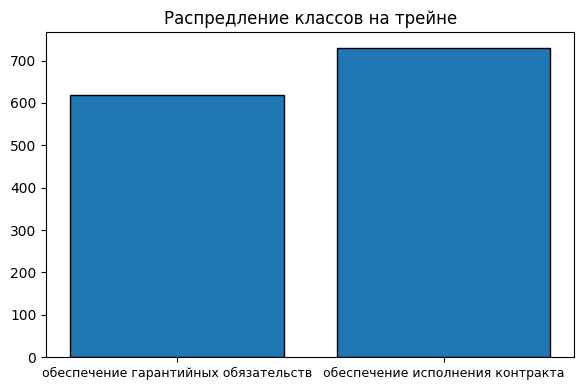

In [ ]:
group_count = train.groupby(["label"]).count()
plt.figure(figsize=(6, 4))
plt.bar(group_count.index, group_count.iloc[:, 0].tolist(), edgecolor="black")
plt.title("Распредление классов на трейне")
plt.tick_params(axis="x", labelsize=9)
plt.tight_layout();

*Сильного дисбаланса нет, поэтому можно не прибегать к дополнительному сэмплированию*

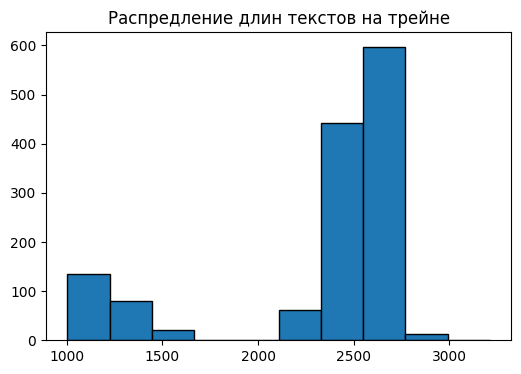

In [ ]:
text_lengths = train.text.apply(lambda t: len(t))

plt.figure(figsize=(6, 4))
plt.hist(text_lengths, edgecolor="black")
plt.title("Распредление длин текстов на трейне");

*Также видим, что тексты в датасете достаточно длинные, и после токенизации много из них явно превысят 512 токенов (это я проверяла). Учтем это в токенизаторе*

*Далее предобрабатываем данные для модели Question Answering. Подаем модели на вход токены в формате `[CLS] <label tokens> [SEP] <text tokens> [SEP]`. Помимо добавления спец токенов, добавляем лейблы 0 и 1, которые помечают положение ответа в тексте (на каждый токен по паре 0 и 1, так один и тот же токен может быть началом и концом. Если ответ в тексте есть, то CLS токен будет помечен как (0,0), а ответ как (1, 0)....(0, 1), а если нет или он есть только частично, то 1-цами будет помечаться только CLS токен. Помимо этого, так как BERT в параметры токенизатора добавляем stride и overflow. Тексы будут дробиться на части по 512 токенов с пересечением, причем пересечение сильно больше длины лейбла, поэтому искомый кусок (ответ) будет либо в обоих частях, либо в 1. Таким образом, немного повышаем количество входов, где есть таргет, что хорошо для обучения модели. Параметр offset_mapping нужен для восстановления исходных положений токенов*

In [ ]:
def tokenize_for_qa(dataset, question, context):
    """
    Tokenizes dataset for QA model

    Args:
        dataset (`datasets.Dataset`):
           Dataset for processing
        question (`str`)
            Question column name (label)
        context (`str`)
            context column name (text)
    Returns:
        `float`: Tokenized & mapped dataset
    """
    return tokenizer(
        dataset[question],
        dataset[context],
        truncation="only_second",
        padding="max_length",
        max_length=MAX_LEN,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )

In [ ]:
def find_labels(offsets, answer_start, answer_end, sequence_ids):
    """
    Finds start and end tokens of the answer in the context
    Args:
        offsets (`array`-like)
            Tokenizetion offsets
        answer_start (`int`)
            Start position of answer in original text
        answer_end (`int`)
            Start position of answer in original text
        sequence_ids (`array`-like)
            Tokenized sequence
    Returns:
        (`int`, `int`): Start and end position of answer in tokenized sequences
    """
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1
    # If there is no answer
    if answer_start == 0 and answer_end == 0:
        return (0, 0)
    # If the answer is not fully in the contex
    elif (
        offsets[context_start][0] > answer_end or offsets[context_end][1] < answer_start
    ):
        return (0, 0)
    else:
        idx = context_start
        while idx <= context_end and offsets[idx][0] <= answer_start:
            idx += 1
        start_position = idx - 1

        idx = context_end
        while idx >= context_start and offsets[idx][1] >= answer_end:
            idx -= 1
        end_position = idx + 1

        return start_position, end_position

*Применим к датасетам:*

In [ ]:
def preprocess_for_qa(dataset):
    """
    Prepares raw dataset for QA model: 
    tokenization -> answer start, end mapping

    Args:
        dataset (`datasets.Dataset`):
           Dataset for processing
    Returns:
        `float`: Tokenized & mapped dataset
    """ 
    questions = [q.strip() for q in dataset["question"]]
    inputs = tokenize_for_qa(dataset, "question", "context")
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    inputs["start_positions"] = []
    inputs["end_positions"] = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        start, end = find_labels(
            offset, dataset["answer_start"][sample_idx], 
            dataset["answer_end"][sample_idx], inputs.sequence_ids(i)
        )
        
        inputs["start_positions"].append(start)
        inputs["end_positions"].append(end)

    return inputs

In [ ]:
raw_datasets =  DatasetDict({"train": train_dataset, "validation": valid_dataset})

datasets = raw_datasets.map(
    preprocess_for_qa,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/1349 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

*Пример:*

In [ ]:
tokenizer.decode(datasets["validation"][2]["input_ids"])

'[CLS] обеспечение исполнения контракта [SEP] Приложение № 4 к извещению УТВЕРЖДАЮ Главный врач БУ « Республиканская психиатрическая больница » Минздрава Чувашии _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ В. В. ерсальный ( ае ) передаточный ( ые ) документ ( ы ) ; в ) товарная ( ые ) накладная ( ые ) / универсальный ( ае ) передаточный ( ые ) документ ( ы ) ; г ) акт ( ы ) приема - передачи Товара ( приложение № 3 к Контракту ), подписанные Поставщиком и Заказчиком. 8. 4. На всех документах, перечисленных в пункте 8. 3. Контракта обязательно должны быть указаны наименование Заказчика, Поставщика, номер и дата Контракта, даты оформления и подписания документов. 8. 5. Оплата по Контракту осуществляется по факту поставки всего Товара, предусмотренного Спецификацией ( приложение № 1 к Контракту ) в течение 7 ( Семь ) рабочих дней с даты подписания Заказчиком в ЕИС документа о приемке, и на основании документов, предусмотренных пунктом 8. 3 Контракта. 8. 6. В случае, если Поставщик в д

In [ ]:
tokenizer.decode(datasets["validation"][3]["input_ids"])

'[CLS] обеспечение исполнения контракта [SEP]. Возврат Поставщику денежных средств, внесенных им на счет Заказчика в качестве обеспечение исполнения Контракта, осуществляется при условии надлежащего исполнения Поставщиком своих обязательств по Контракту не позднее 15 ( Пятнадцать ) дней. Денежные средства перечисляются по банковским реквизитам Поставщика, указанным в настоящем Контракте. 9. 2. 3. В случае неисполнения или ненадлежащего исполнения Поставщиком обеспеченных внесением денежных средств обязательств, Заказчик имеет право удержать из внесенных Поставщиком денежных средств сумму, равную сумме денежных средств, которую Поставщик обязан уплатить Заказчику в качестве неустойки ( штрафов, пеней ) или в качестве возмещения убытков, либо иной сумме денежны Представители Заказчика : _ _ _ _ _ _ _ _ _ _ _ _ _ _ / _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ / _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ / _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

*Получили разделение текстов по кускам с пересечением. Для каждого из них будет строиться предсказание*

*Делим датасеты на батчи с помощью DataCollator*

In [ ]:
default_data_collator = DefaultDataCollator()

*Задаем модель и параметры Trainer-a*

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(bert_model)
model.to(DEVICE)
clear_output()

In [ ]:
def custom_compute_metrics(eval_pred):
    """
    Calculates accuracy score of exact match
    of start and end positions

    Args:
        eval_pred (`QuestionAnsweringModelOutput`):
           Model outputs
    Returns:
        `float`: Accuracy score
    """
    start_logits, end_logits = eval_pred.predictions
    answer_starts, answer_ends = eval_pred.label_ids

    y_true = np.column_stack((answer_starts, answer_ends))
    preds = np.column_stack(
        (np.argmax(start_logits, axis=-1), np.argmax(end_logits, axis=-1))
    )
    comparison = np.equal(y_true, preds)
    matching_rows = np.all(comparison, axis=1)
    matching_pairs = np.sum(matching_rows)
    accuracy = matching_pairs / y_true.shape[0]

    return {"Accuracy": accuracy}


training_args = TrainingArguments(
    output_dir=f"{WORK_FOLDER}/Runs",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    logging_dir=f"{WORK_FOLDER}/Runs",
    remove_unused_columns=False,
    label_names=["start_positions", "end_positions"],
    include_inputs_for_metrics=True,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="Accuracy",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    data_collator=default_data_collator,
    compute_metrics=custom_compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model(f'{WORK_FOLDER}/base_model')

*Кривые обучения*

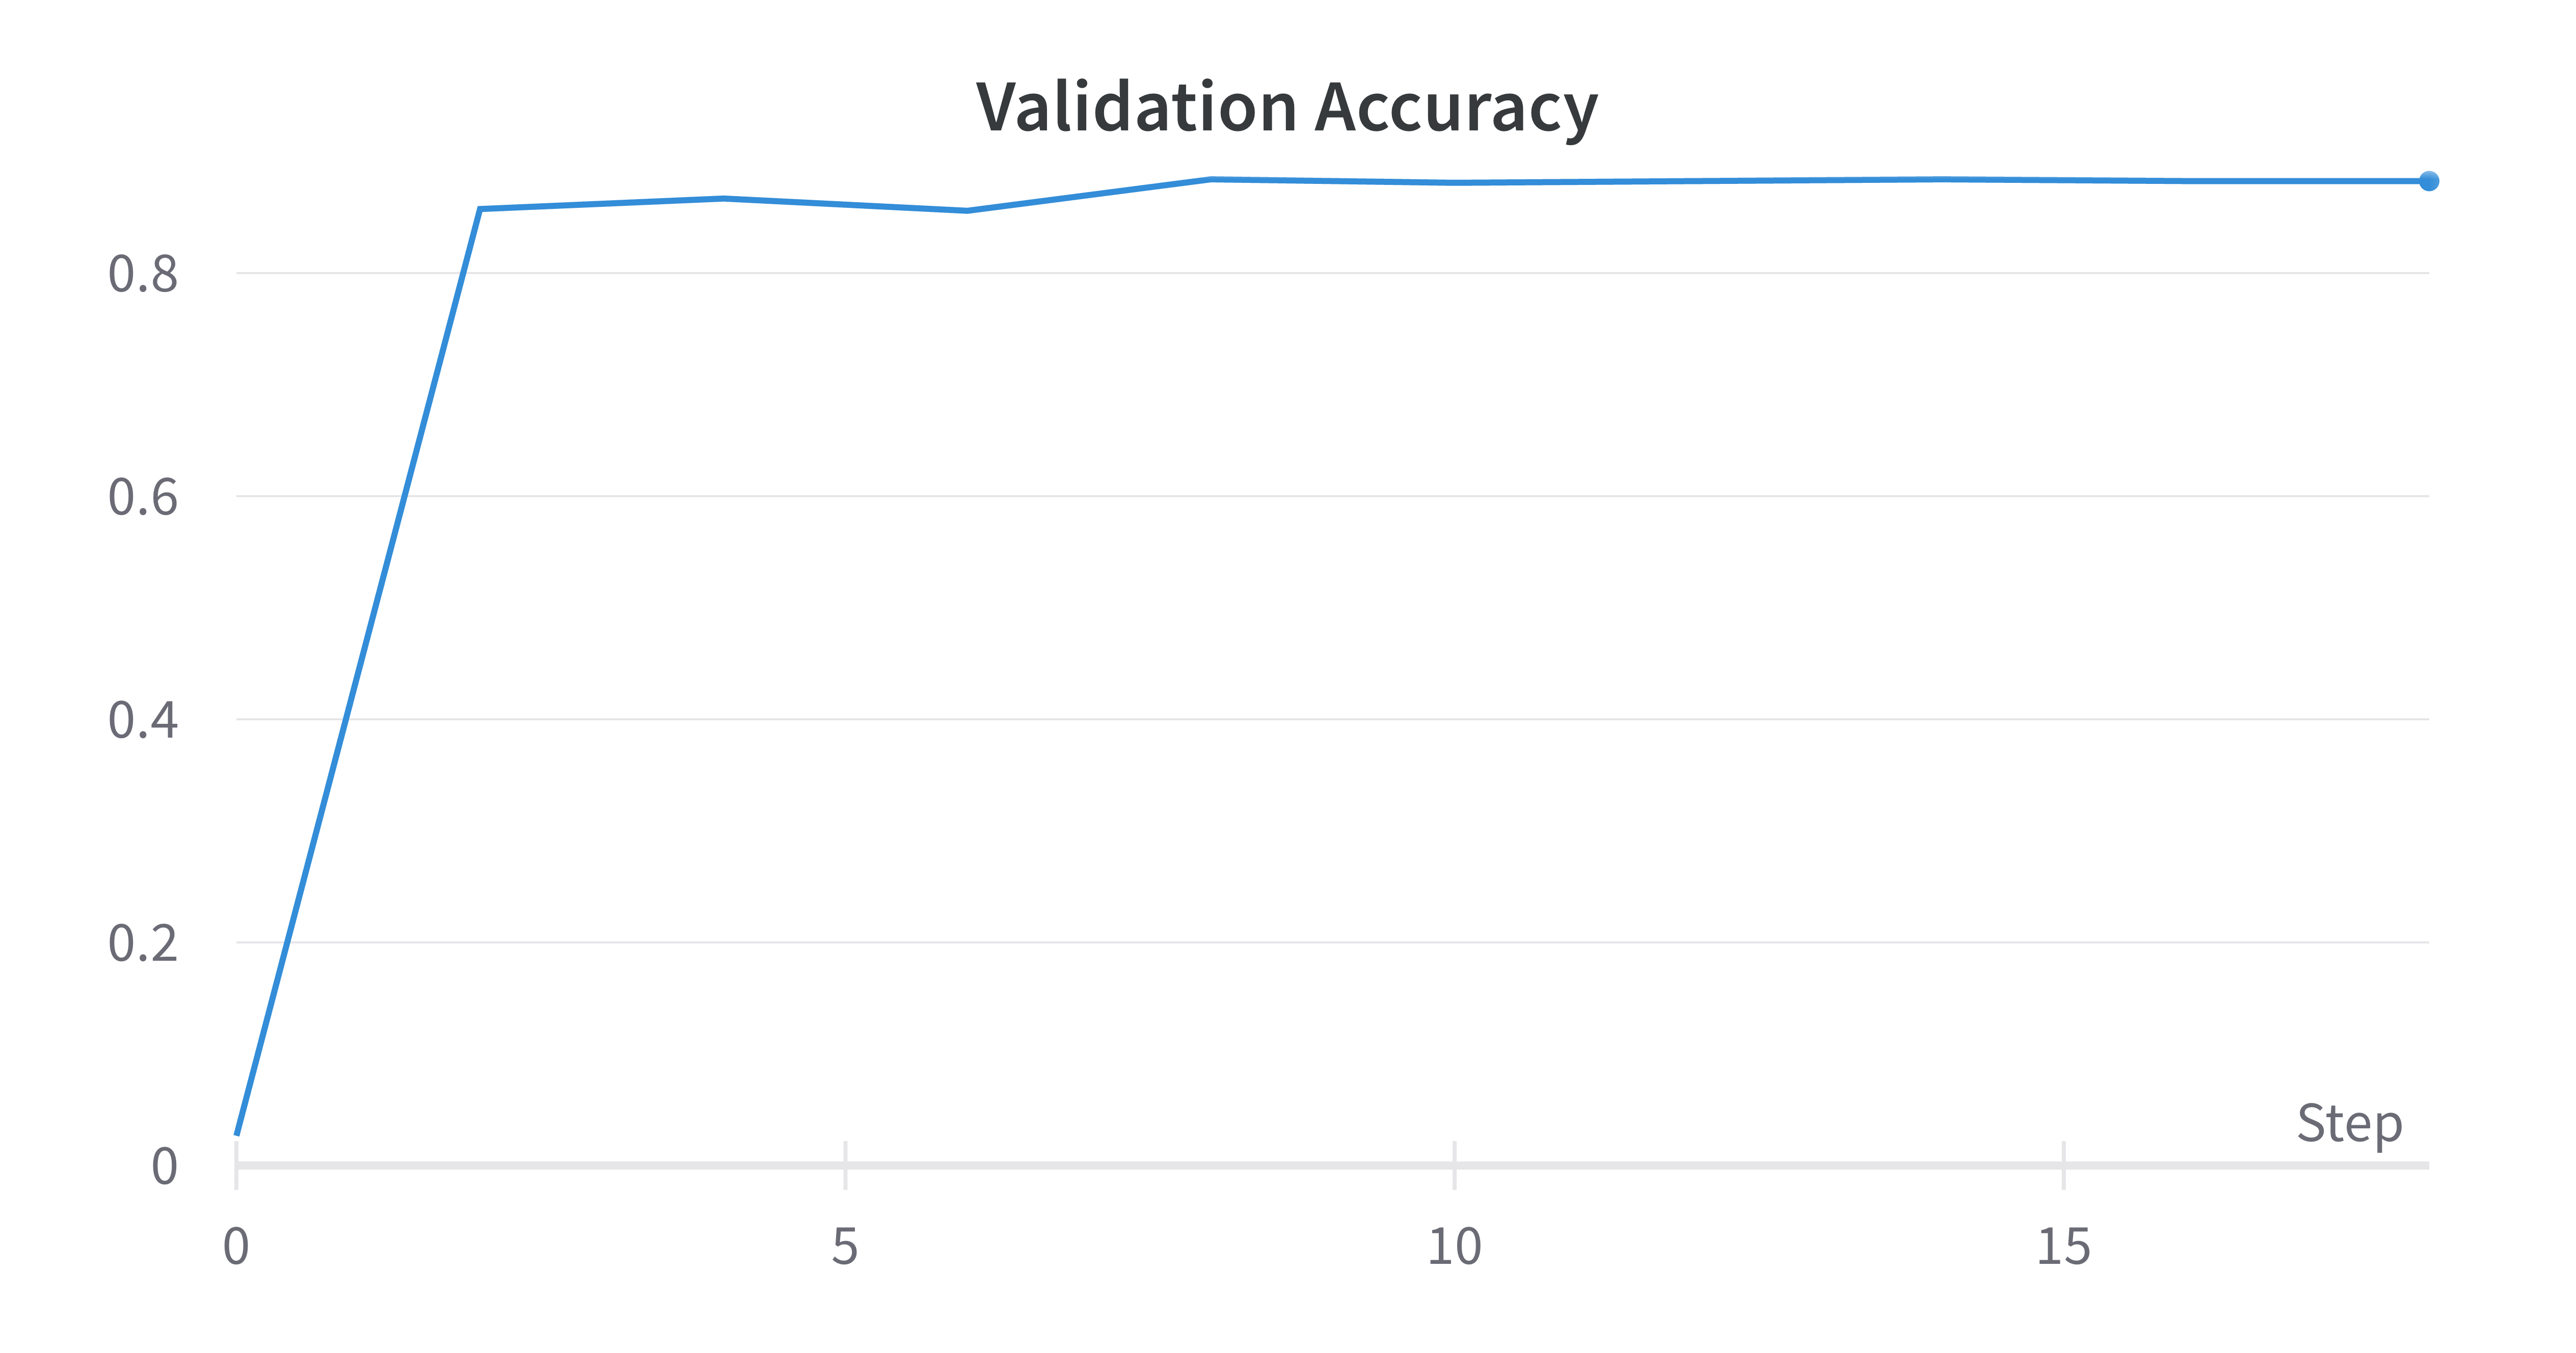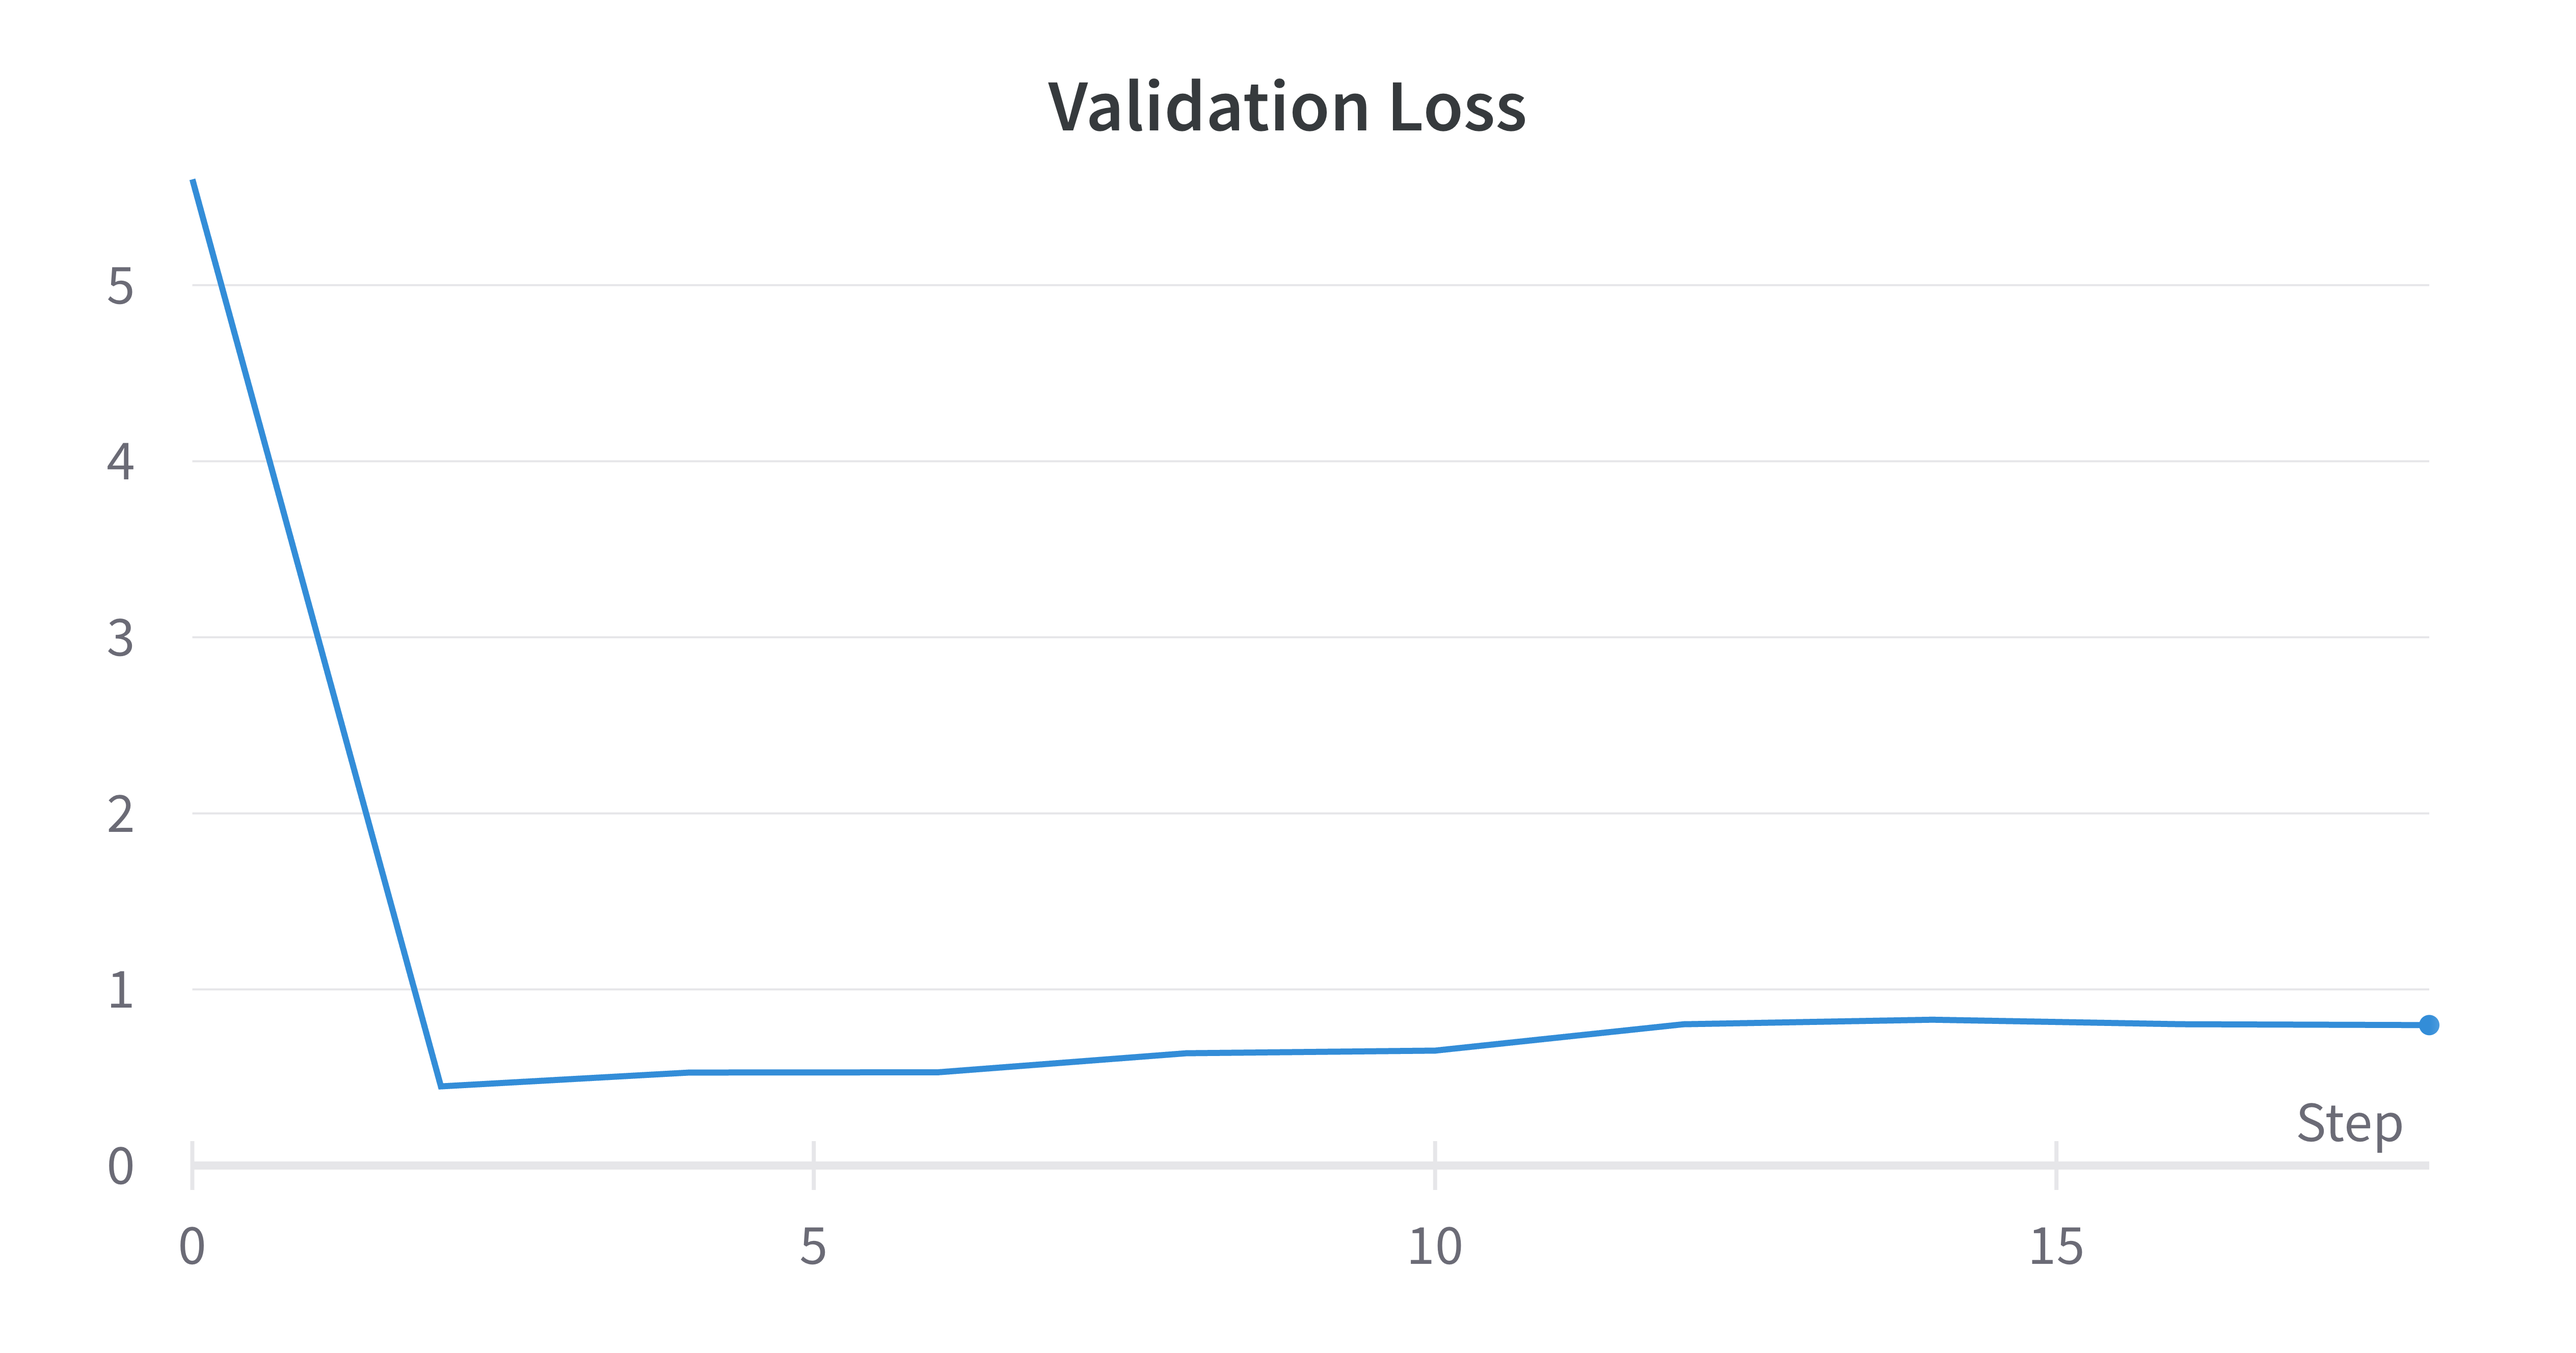

*Получился максимальный Accuracy 0.88 (на токенизированной валидации!)*

*Попробуем добавить регуляризацию, и снизить скорость обучения.*

In [ ]:
training_args.warmup_steps = 500
training_args.weight_decay = 0.01
training_args.learning_rate = 1e-6

model = AutoModelForQuestionAnswering.from_pretrained(bert_model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    data_collator=default_data_collator,
    compute_metrics=custom_compute_metrics
)
wandb.init()
trainer.train()

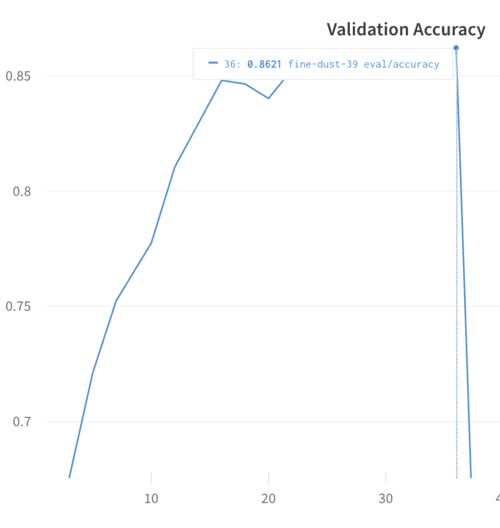

*Не помогло, скор на валидации получается ниже. Попробуем без регуляризации, но с той же сниженной скоростью обучения*

In [ ]:
training_args.weight_decay = 0.

model = AutoModelForQuestionAnswering.from_pretrained(bert_model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    data_collator=default_data_collator,
    compute_metrics=custom_compute_metrics
)
trainer.train()

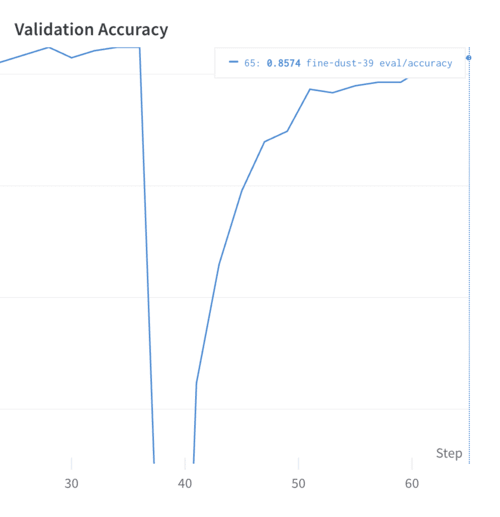

*Опять скор после того же кол-ва эпох ниже чем у бейзлайн модели*

*Попробуем все таки сбалансировать классы, так как выборки небольшие, и это может все таки ухудшать предсказательную способность. Использую over sampling более редкого класса*

In [ ]:
class_count_0, class_count_1 = train['label'].value_counts()

class_0 = train[train['label'] == 'обеспечение исполнения контракта']
class_1 = train[train['label'] == 'обеспечение гарантийных обязательств']

class_1_over = class_1.sample(class_count_0, replace=True)

train_balanced = pd.concat([
    class_0, class_1_over
    ], axis=0).sample(frac=1)

In [ ]:
class_count_0, class_count_1 = validation['label'].value_counts()

class_0 = validation[validation['label'] == 'обеспечение исполнения контракта']
class_1 = validation[validation['label'] == 'обеспечение гарантийных обязательств']

class_1_over = class_1.sample(class_count_0, replace=True)

validation_balanced = pd.concat([
    class_0, class_1_over
    ], axis=0).sample(frac=1)

*Делаем те же действия что и до запуска базовой модели*

In [ ]:
train_dataset = Dataset.from_dict({
    "context": train_balanced["text"],
    "question": train_balanced["label"],
    "answer_start": train_balanced["answer_start"],
    "answer_end": train_balanced["answer_end"],
})

valid_dataset = Dataset.from_dict({
    "context": validation_balanced["text"],
    "question": validation_balanced["label"],
    "answer_start": validation_balanced["answer_start"],
    "answer_end": validation_balanced["answer_end"],
})

raw_datasets =  DatasetDict({"train": train_dataset, "validation": valid_dataset})

datasets = raw_datasets.map(
    preprocess_for_qa,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    data_collator=default_data_collator,
    compute_metrics=custom_compute_metrics,
)

In [ ]:
trainer.train()

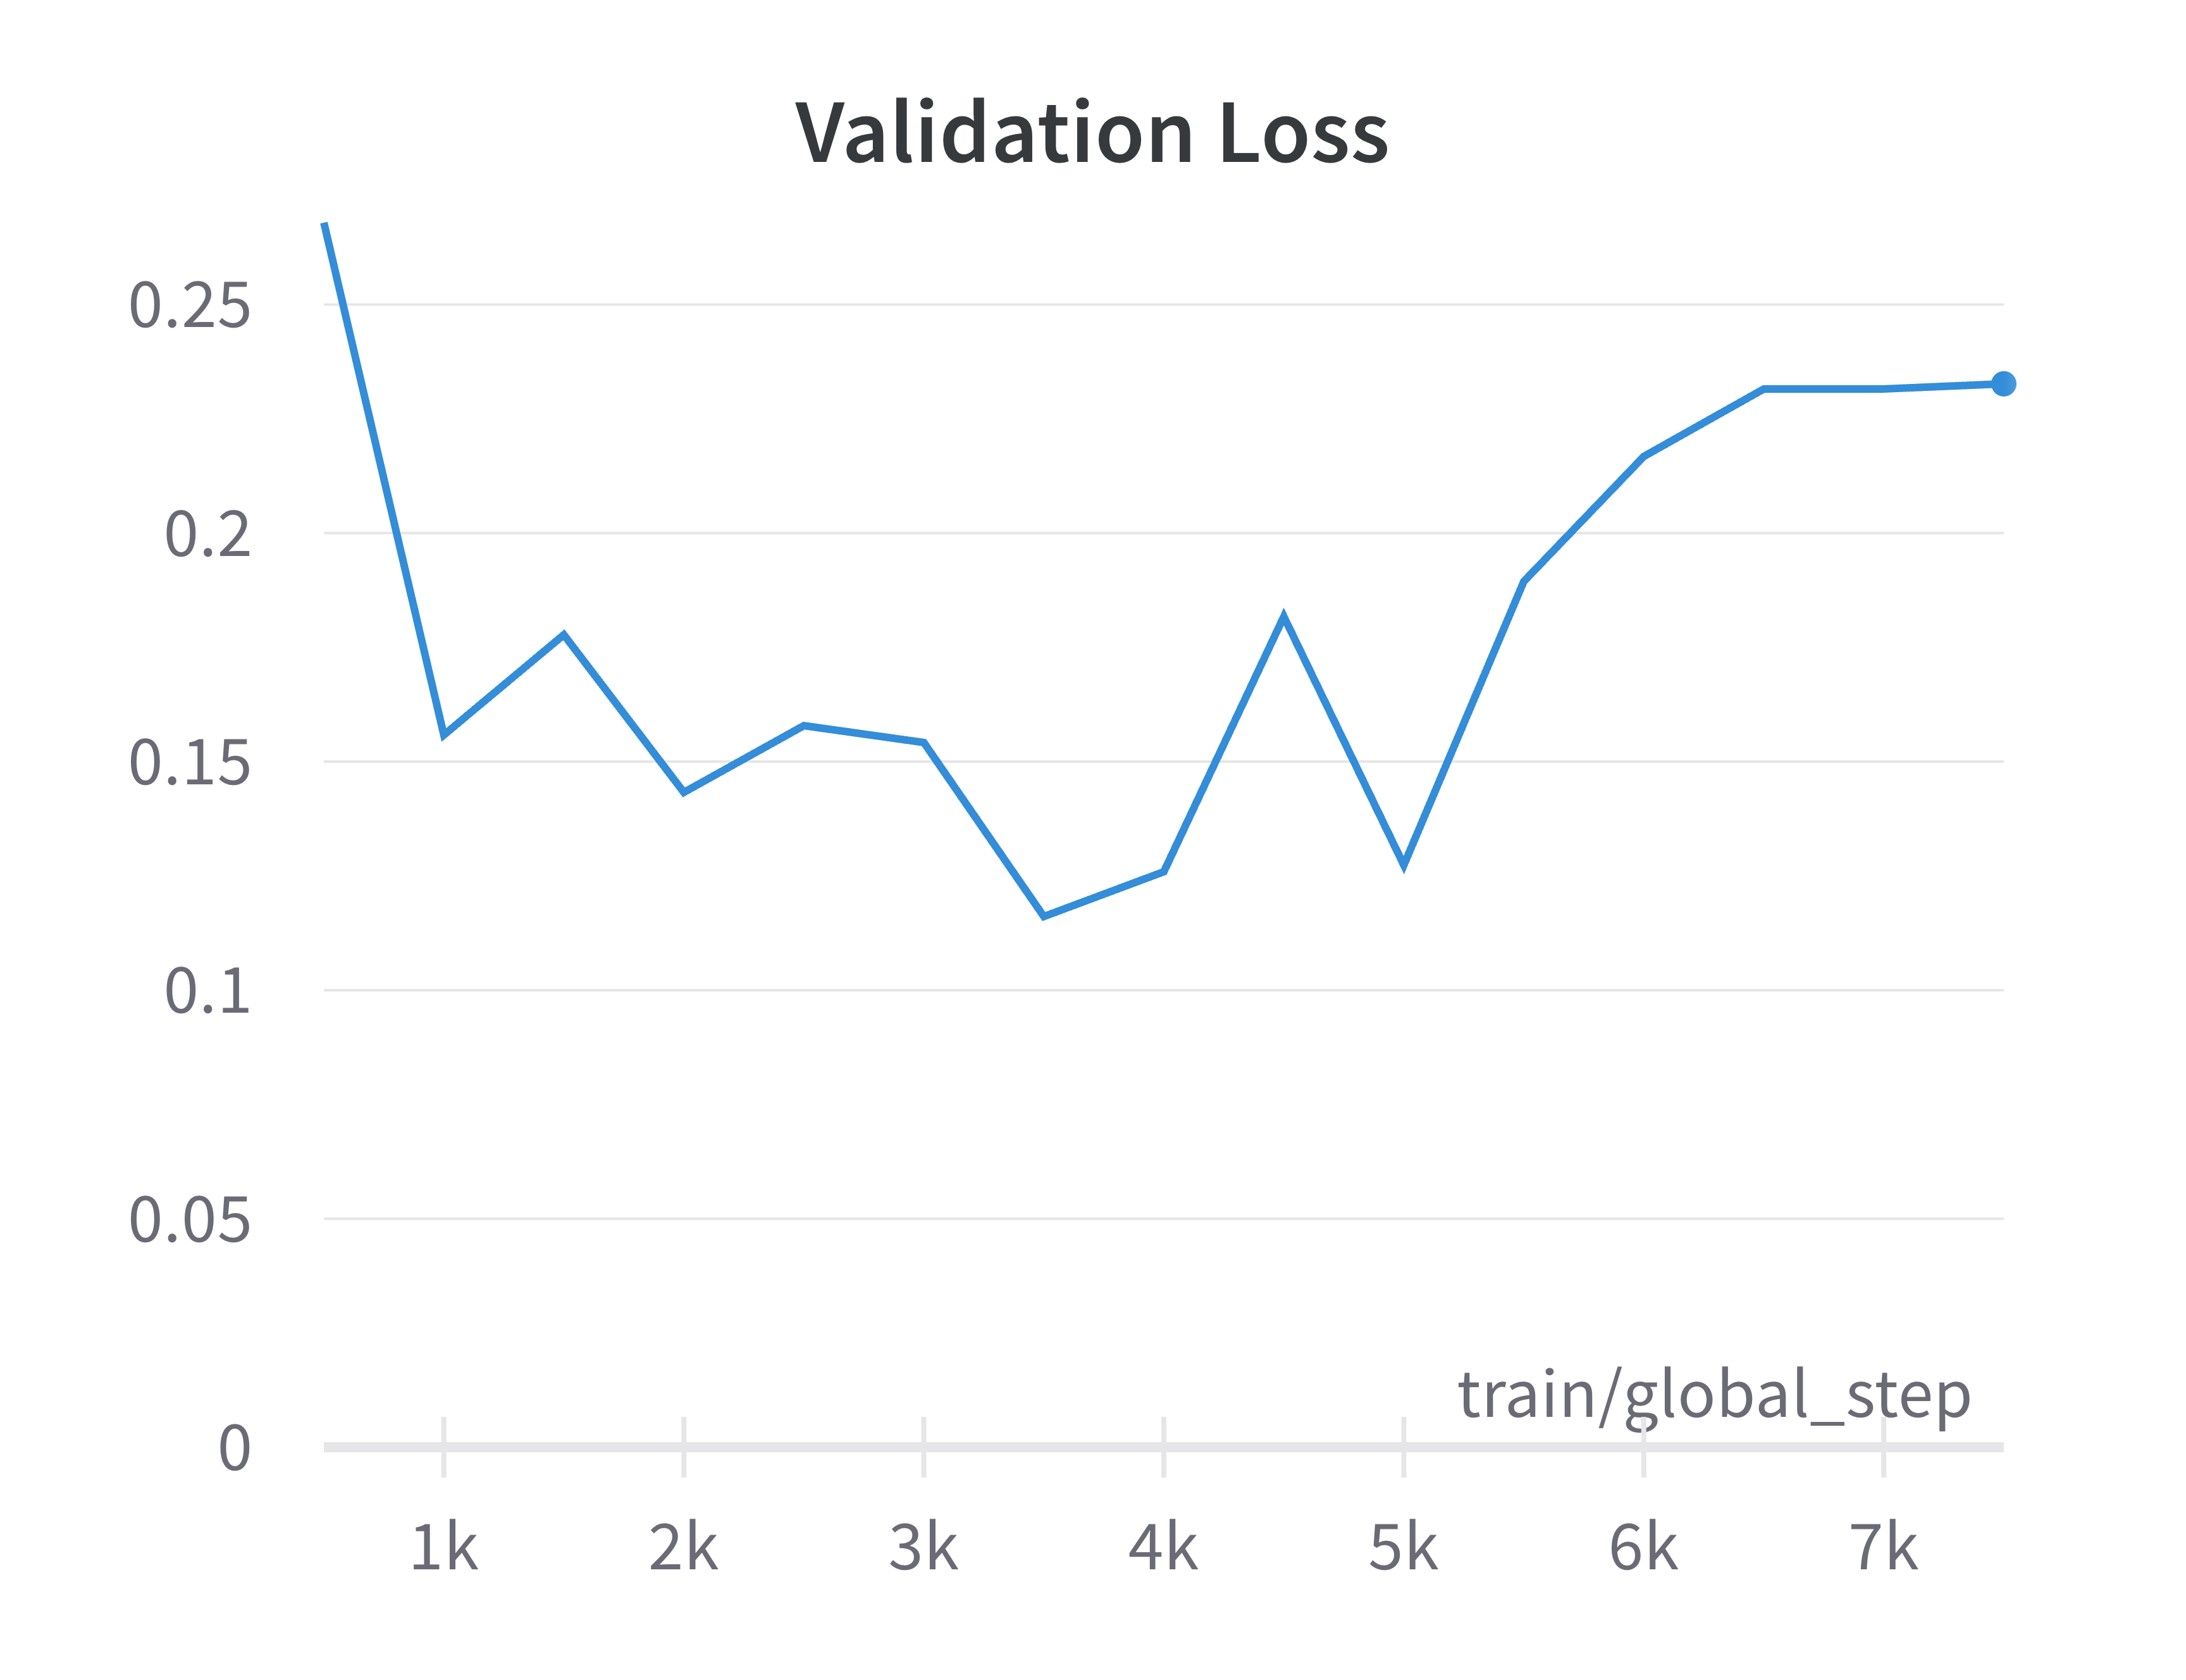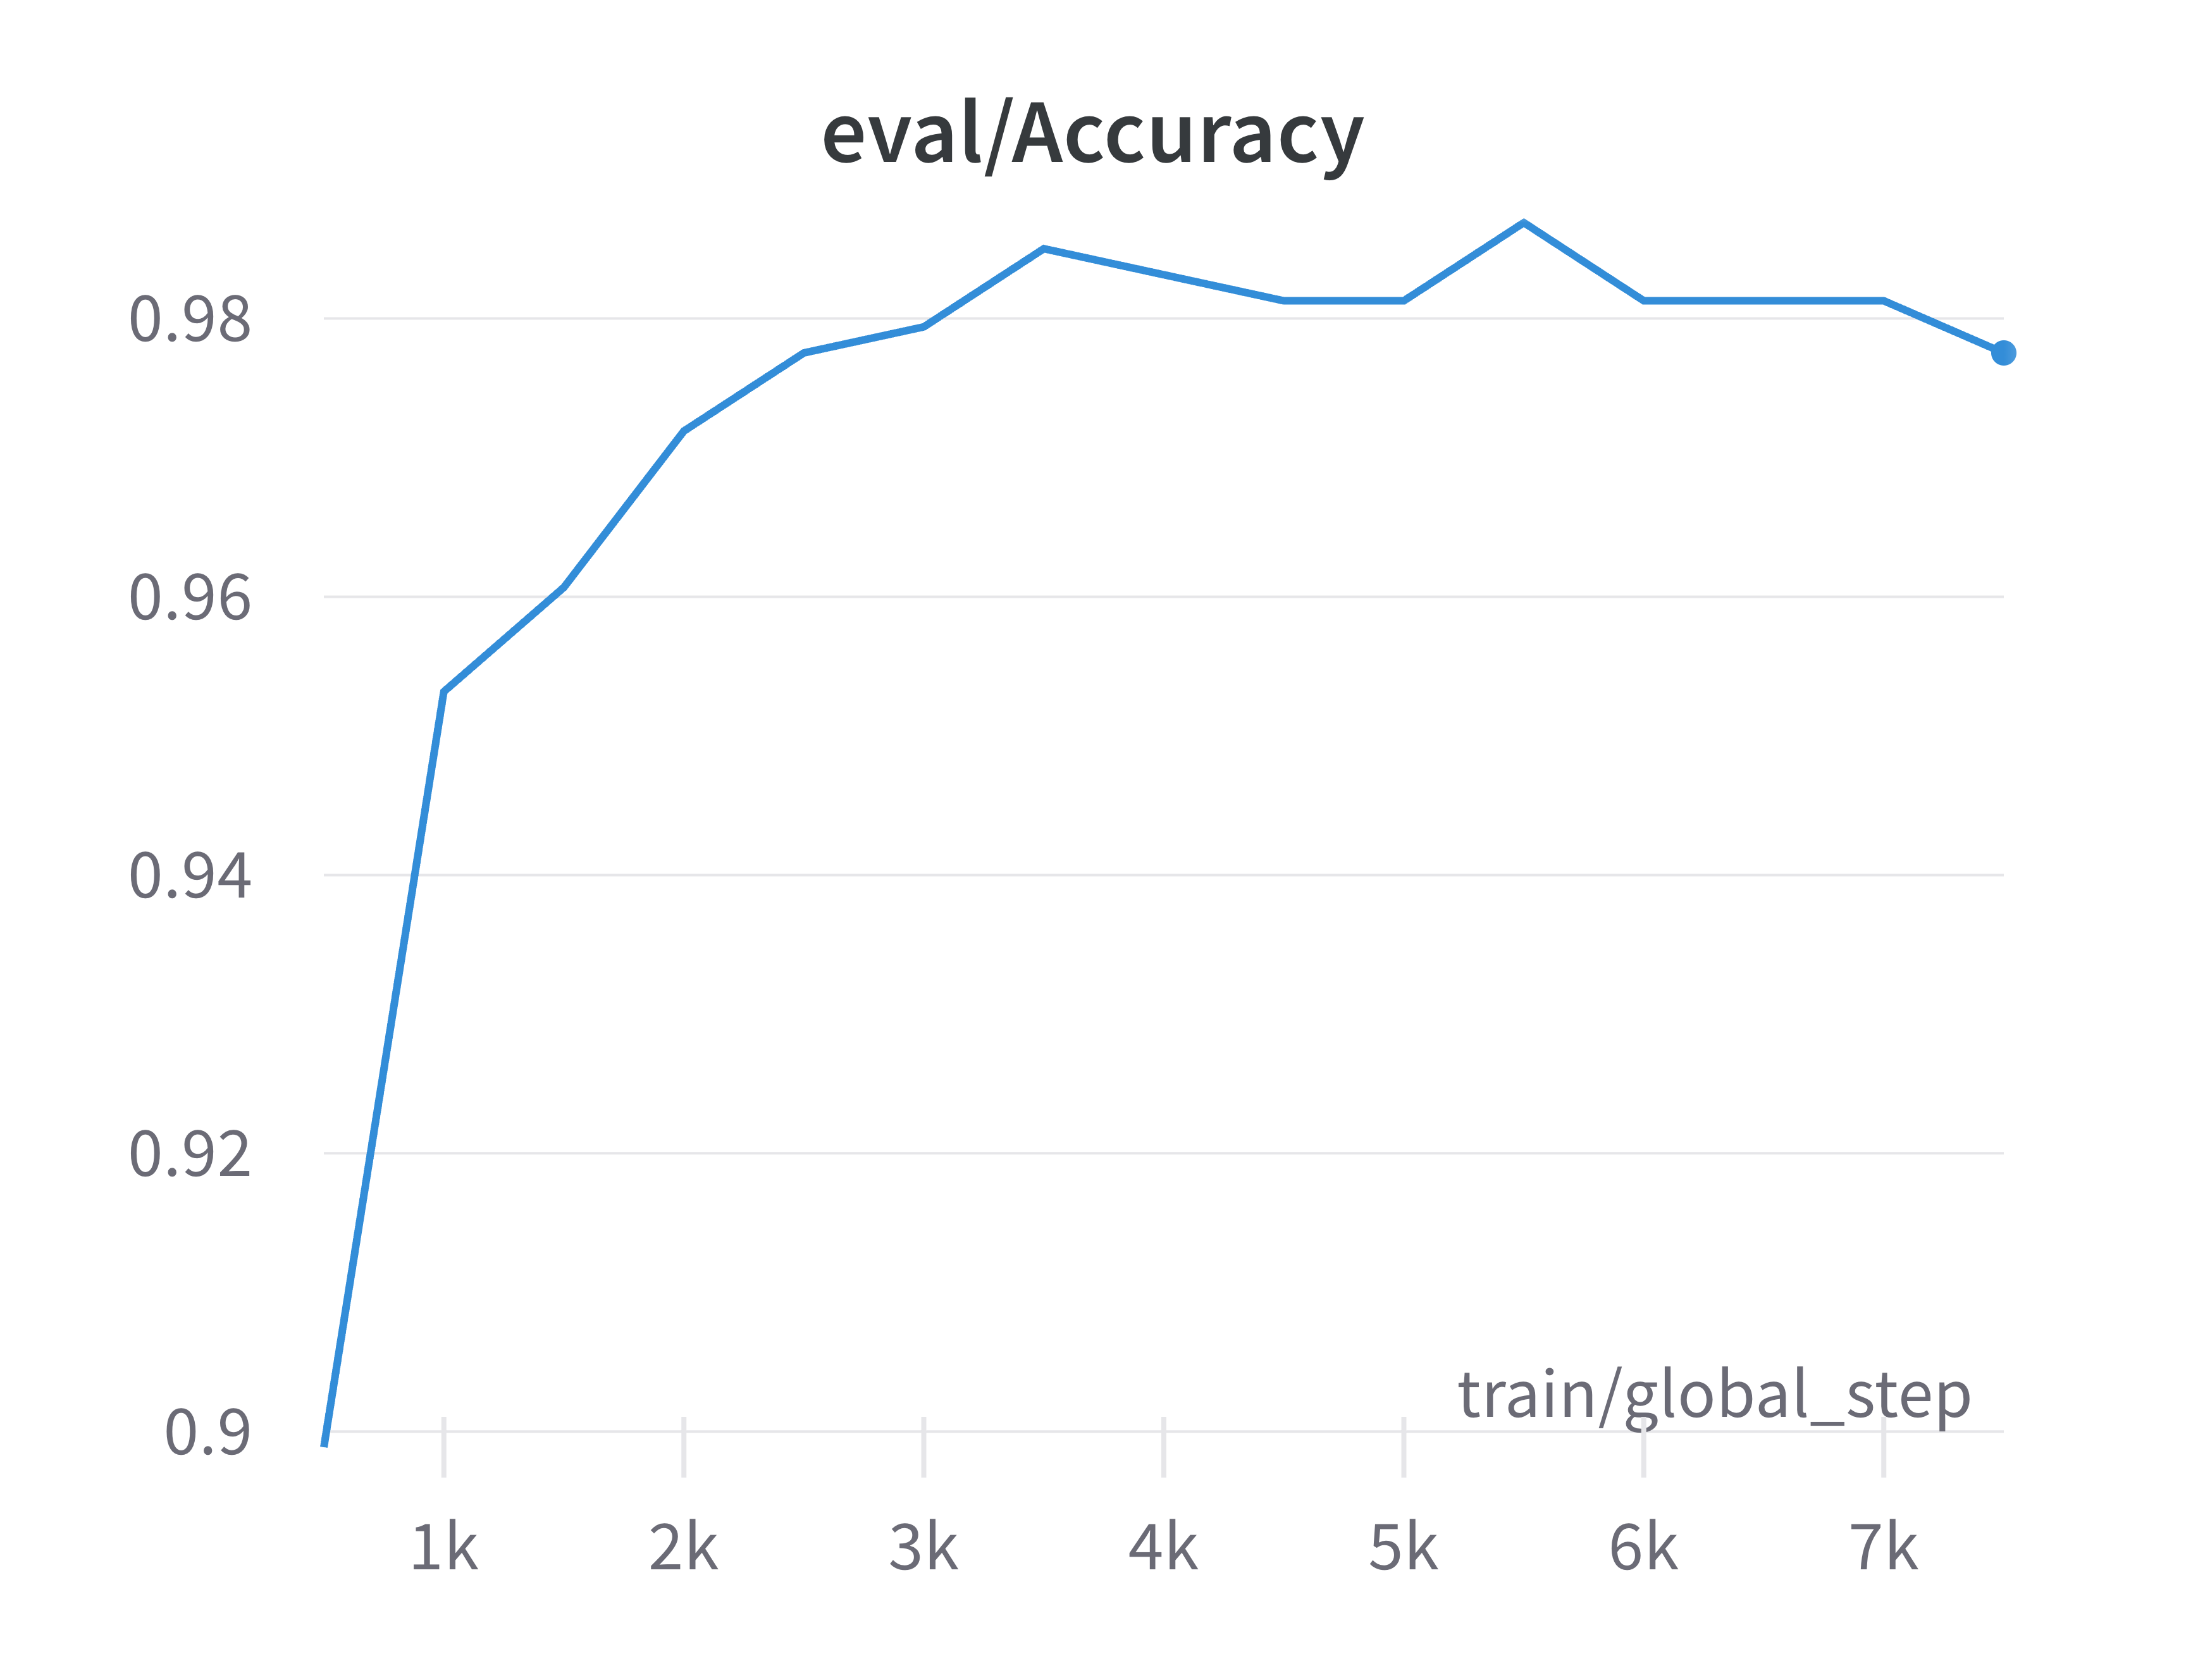

*Получилось повысить метрику. Загружаем лучшие веса (по паре best Accuracy - lowest loss) нашей обученной модели для инференса*

In [ ]:
model.load_state_dict(torch.load(
    f"{WORK_FOLDER}/Runs/checkpoint-5500/pytorch_model.bin",
    map_location=torch.device('cpu')
    )
)

<All keys matched successfully>

*Для получения предсказаний на необработанном датасете придется написать функцию вручную. Почему: по той же самой причине, что у нас тексты очень длинные. Для evaluation во время обучения используется токенизированный валидационный датасет, который содержит больше элементов, чем исходный из-за дробления на куски по 512 токенов. Соответственно скор считается на нем, а нам нужно получить предсказание и скор для ***исходного*** валидационного датасета. Для этого нужно получить предсказания для каждой части исходных тектов, а затем взять наиболе вероятные.*

*PS: думаю, скорее всего возможно написать кастомный `pipeline` из transformers для инференса, а не делать все в своей функции, но пока не было времени с ним разобраться*

In [ ]:
EMPTY_PREDICTION = {"text": "", "answer_start": 0, "answer_end": 0}


def predict(data):
    """
    Makes model predictions on raw data

    Args:
        data (`pd.Series` row):
           A row of pd.Dataframe
    Returns:
        `dict`: {
                'text': decoded,
                'answer_start': answer_start,
                'answer_end': answer_end
            }
    """
    with torch.no_grad():
        tokenized = tokenize_for_qa(data, "label", "text")

        # get predictions of answer starts and ends for each chunk
        out = model(
            torch.tensor(torch.tensor(tokenized["input_ids"]).to(DEVICE)),
            torch.tensor(torch.tensor(tokenized["attention_mask"]).to(DEVICE)),
        )
        start_logits = out["start_logits"].cpu()
        end_logits = out["end_logits"].cpu()

        # get most probable prediction and its location
        # start and end chunk should be the same so choose chunk by start logit
        start_argmax = start_logits.argmax(-1)
        chunk =  start_argmax.argmax()
        start_pred = start_argmax[chunk]
        end_pred = end_logits.argmax(-1)[chunk]

        predict_answer_tokens = np.array(tokenized["input_ids"])[
            chunk, start_pred : end_pred + 1
        ]
        if start_pred == 0 and end_pred == 0:
            return EMPTY_PREDICTION
        else:
            # get decoded answer and positions in original text
            offset_mapping_chunk = tokenized["offset_mapping"][chunk]
            answer_start = offset_mapping_chunk[start_pred][0]
            answer_end = offset_mapping_chunk[end_pred][1]
            decoded = data["text"][answer_start:answer_end]
            return {
                "text": decoded,
                "answer_start": answer_start,
                "answer_end": answer_end,
            }

In [ ]:
validation_results = validation.apply(predict, axis=1)
valid_preds = validation_results.apply(
    lambda x: np.array([x["answer_start"], x["answer_end"]])
)
valid_preds = valid_preds.tolist()

In [ ]:
y_true = np.array(validation[["answer_start", "answer_end"]])
print(
    "Реальный Accuracy 1 модели на валидации:", np.round(accuracy_eval(y_true, valid_preds), 3)
)

Реальный Accuracy 1 модели на валидации: 0.809


*Ну чтож, на валидации получилась неплохая точность - почти 81%. В целом, насколько я знаю, в NLP задачах точность выше 70% считается реалистично хорошей. Конечно, на тесте она немного упадет, но думаю как раз останется в районе к 70-80%. Так же хочу отметить, что в таких задачах помимо exact match (accuracy) чаще используют метрику F1, или обе - так называемую squad. Возможно модель показала бы еще лучший результат с ней. Хотя бы потому, что ***есть случаи, когда верно предсказан answer_start, но неверно answer_end - а это частично верное предсказание***, и по метрике F1 давало бы ненулевое значение. Но отбор будет по Accuracy, так что смотрю только по ней, и готова продолжить исследование дальше если возьмете меня:)*

*Повторяем на тесте и сохраняем полученные результаты*

In [ ]:
test_results = test.apply(predict, axis=1)
test["extracted_part"] = test_results
test.to_csv(f"{WORK_FOLDER}/predictions.csv")

In [ ]:
with open(f'{WORK_FOLDER}/dataset/test.json', 'r', encoding='utf-8') as file:
    test_json = json.load(file)

for i, entry in enumerate(test_json):
    entry["extracted_part"] = test["extracted_part"].iloc[i]

with open(f'{WORK_FOLDER}/predictions.json', 'w', encoding='utf-8') as file:
    json.dump(test_json, file, indent=2, ensure_ascii=False)

***Спасибо за задание, было очень инетересно!***